In [1]:
# # run only to verify the dataset read op
# import numpy as np
# import pandas as pd

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/intel-image-classification'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2024-04-09 04:33:58.624345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 04:33:58.624444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 04:33:58.781121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = "/kaggle/input/seg_train/seg_train/"
test_data_dir = "/kaggle/input/seg_test/seg_test/"

num_classes = 6
img_width = 150
img_height = 150
batch_size = 64
seed = 1

In [4]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [5]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [6]:
val_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [7]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    seed=seed,
    shuffle=False,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 3000 images belonging to 6 classes.


In [8]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

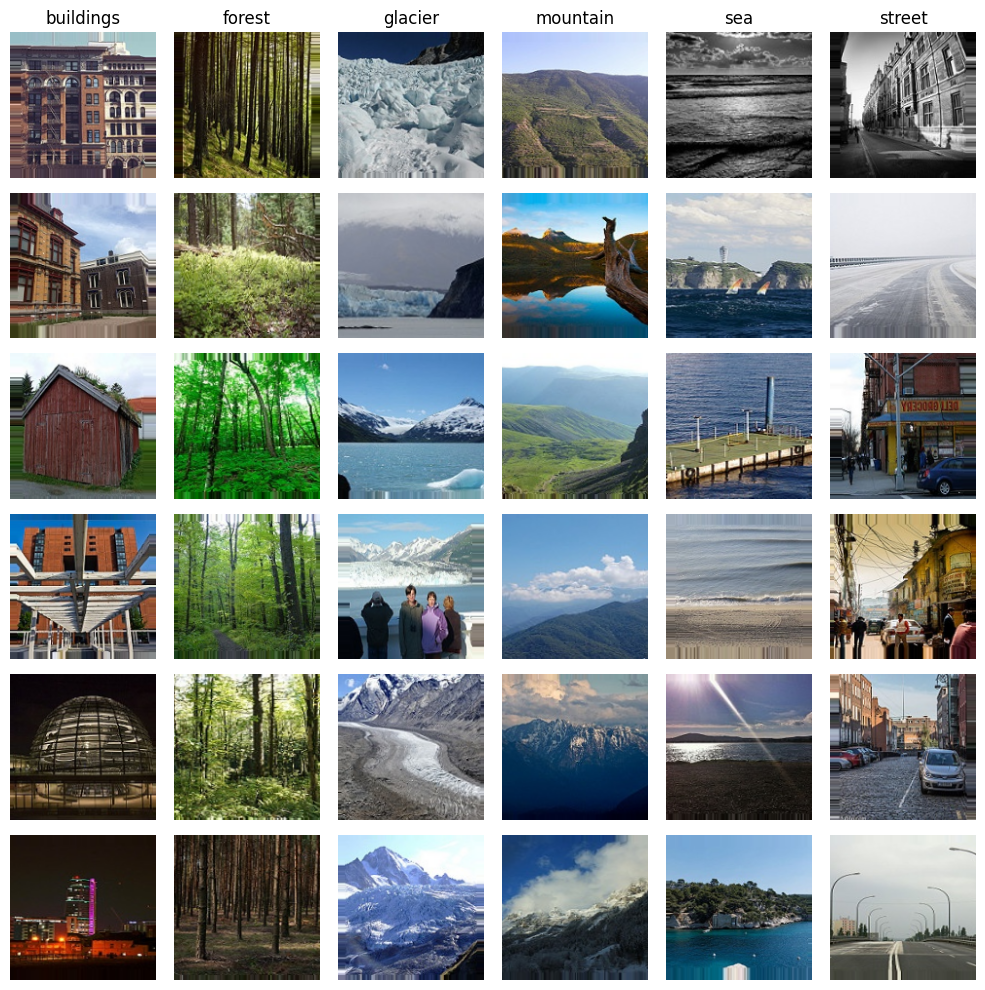

In [9]:
import matplotlib.pyplot as plt
import numpy as np

class_labels = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(6, 6, figsize=(10, 10))

for i, class_label in enumerate(class_labels):
    images, _ = next(iter(train_generator))
    
    # Get indices of images belonging to the current class
    class_indices = np.where(np.argmax(_, axis=1) == i)[0]
    
    # Get random indices for selecting 6 images
    random_indices = np.random.choice(class_indices, 6, replace=False)
    
    for j, index in enumerate(random_indices):
        # Display the j-th randomly selected image of the current class in the corresponding subplot
        ax = axes[j, i]
        ax.imshow(images[index])
        ax.axis('off')
        if j == 0:
            ax.set_title(class_label)

plt.tight_layout()
plt.show()

# Commonly used function definitions

In [10]:
def plot_learning_curve(history_):
    training_loss = history_.history['loss']
    validation_loss = history_.history['val_loss']
    training_accuracy = history_.history['accuracy']
    validation_accuracy = history_.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_on_test_dataset(model_):
    test_loss, test_accuracy = model_.evaluate(test_generator)
    print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

In [12]:
# this test set is to find the worst classified example (without having to use the test_generator)
test_set = list()
for i in range(47):
    x_, y_ = test_generator[i]
    test_set.extend(zip(x_, y_))

In [13]:
def plot_worst_classified_examples(preds):    
    # Find misclassified examples
    worst_misclassifications = dict()
    for i, (x, y_true) in enumerate(test_set):
        pred_label = np.argmax(preds[i])
        true_label = np.argmax(y_true)
        if pred_label != true_label:
            prob_diff = preds[i][pred_label] - preds[i][true_label]
            if true_label not in worst_misclassifications:
                worst_misclassifications[true_label] = (x, prob_diff, pred_label)
            else:
                if worst_misclassifications[true_label][1] < prob_diff:
                    worst_misclassifications[true_label] = (x, prob_diff, pred_label)

#     # prints images 1 by 1
#     for key, value in worst_misclassifications.items():
#         true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
#         pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[1])
#         plt.imshow(value[0])
#         plt.title(f"True: {true_lbl}, Pred: {pred_lbl}")
#         plt.axis('off')
#         plt.show()
    
    # prints images as subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    for idx, (key, value) in enumerate(worst_misclassifications.items()):
        true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
        pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[2])
        
        r, c = (0, idx) if idx <= 2 else (1, idx-3)
        axs[r, c].imshow(value[0])
        axs[r, c].set_title(f"True: {true_lbl}, Pred: {pred_lbl}")
        axs[r, c].axis('off')

    plt.tight_layout()
    plt.show()

# 1. A simple CNN Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/176 ━━━━━━━━━━━━━━━━━━━━ 45:55 16s/step - accuracy: 0.0625 - loss: 1.8019

I0000 00:00:1712637361.076521     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712637361.094191     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.4666 - loss: 1.3236

W0000 00:00:1712637480.522284     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 166s 859ms/step - accuracy: 0.4672 - loss: 1.3224 - val_accuracy: 0.6487 - val_loss: 0.9495
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 513ms/step - accuracy: 0.6858 - loss: 0.8607 - val_accuracy: 0.6541 - val_loss: 0.9137
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 505ms/step - accuracy: 0.7225 - loss: 0.7629 - val_accuracy: 0.7250 - val_loss: 0.7360
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 511ms/step - accuracy: 0.7603 - loss: 0.6601 - val_accuracy: 0.7767 - val_loss: 0.6325
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 511ms/step - accuracy: 0.7733 - loss: 0.6327 - val_accuracy: 0.7796 - val_loss: 0.6072
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 506ms/step - accuracy: 0.7834 - loss: 0.6099 - val_accuracy: 0.7739 - val_loss: 0.6119
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 512ms/step - accuracy: 0.8052 - loss: 0.5372 - val_accuracy: 0.8006 - val_loss: 0.5544
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 514ms/step - accuracy: 0.8124 - loss: 0.5189 - va

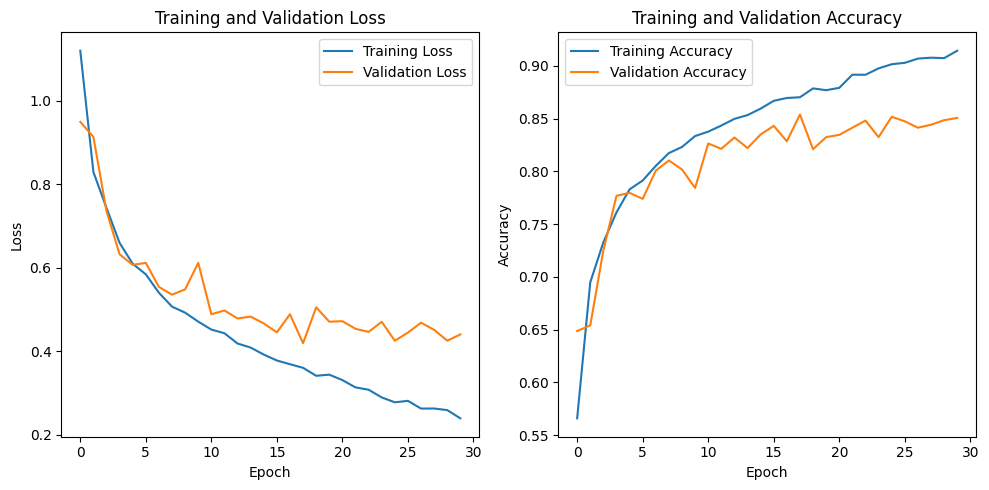

In [18]:
plot_learning_curve(history)

In [19]:
evaluate_on_test_dataset(model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - accuracy: 0.8448 - loss: 0.4583
Test Loss: 0.4702276587486267
Test Accuracy: 0.8399999737739563


In [20]:
predictions = model.predict(test_generator)

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step 

W0000 00:00:1712640301.895212     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 415ms/step


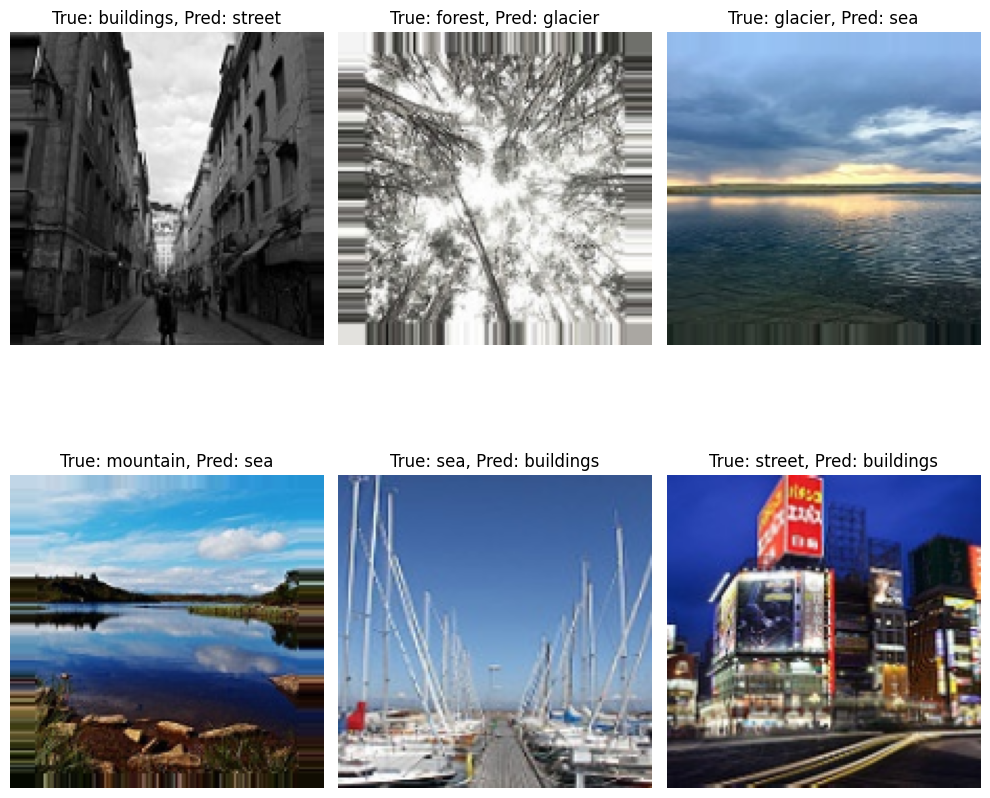

In [21]:
plot_worst_classified_examples(predictions)

# 2. A Model similar to Inception V3

In [22]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation

model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [23]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,661,606 (29.23 MB)

 Trainable params: 7,661,606 (29.23 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model2.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
history2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
  1/176 ━━━━━━━━━━━━━━━━━━━━ 1:21:55 28s/step - accuracy: 0.1719 - loss: 1.7925

W0000 00:00:1712640392.397269     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/176 ━━━━━━━━━━━━━━━━━━━━ 1:12 633ms/step - accuracy: 0.3443 - loss: 1.5655

W0000 00:00:1712640430.344093     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.4436 - loss: 1.3657

W0000 00:00:1712640478.186249     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 138s 627ms/step - accuracy: 0.4441 - loss: 1.3647 - val_accuracy: 0.5977 - val_loss: 0.9945
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 509ms/step - accuracy: 0.6245 - loss: 0.9752 - val_accuracy: 0.6879 - val_loss: 0.8410
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 509ms/step - accuracy: 0.6783 - loss: 0.8599 - val_accuracy: 0.7343 - val_loss: 0.7102
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 511ms/step - accuracy: 0.7112 - loss: 0.7732 - val_accuracy: 0.7753 - val_loss: 0.6331
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 95s 522ms/step - accuracy: 0.7599 - loss: 0.6641 - val_accuracy: 0.7907 - val_loss: 0.5888
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 94s 517ms/step - accuracy: 0.7717 - loss: 0.6196 - val_accuracy: 0.7689 - val_loss: 0.6305
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 509ms/step - accuracy: 0.7751 - loss: 0.6101 - val_accuracy: 0.7832 - val_loss: 0.5823
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 94s 519ms/step - accuracy: 0.7995 - loss: 0.5561 - va

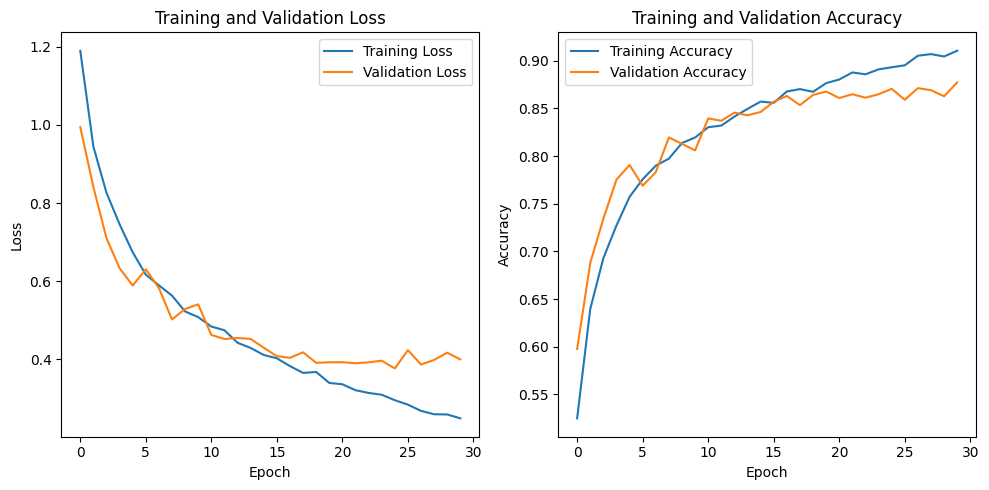

In [27]:
plot_learning_curve(history2)

In [28]:
evaluate_on_test_dataset(model2)

47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 716ms/step - accuracy: 0.8703 - loss: 0.4227
Test Loss: 0.4196716547012329
Test Accuracy: 0.8656666874885559


W0000 00:00:1712643266.940526     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [29]:
predictions2 = model2.predict(test_generator)

 2/47 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step  

W0000 00:00:1712643268.747125     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step


W0000 00:00:1712643289.598376     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


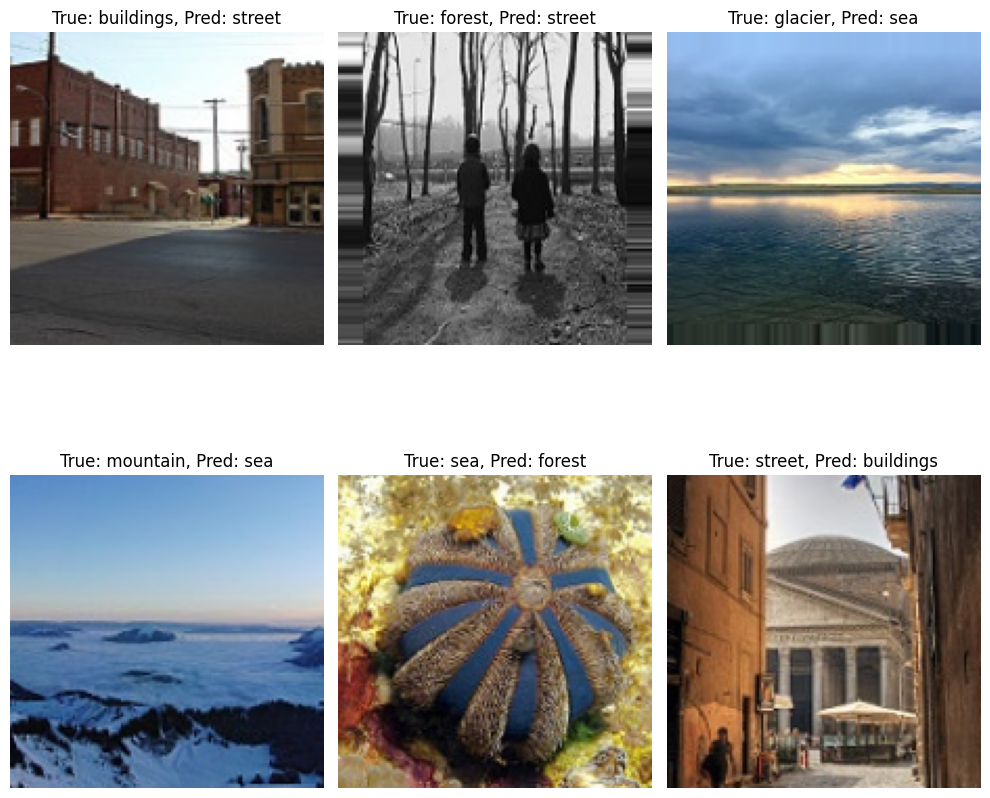

In [30]:
plot_worst_classified_examples(predictions2)